In [ ]:
# === Standard Library ===
import os
import torch
import cv2
import matplotlib.pyplot as plt
from detectron2.utils.logger import setup_logger
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.data import MetadataCatalog, build_detection_test_loader
from detectron2.data.datasets import register_coco_instances
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.utils.visualizer import Visualizer


setup_logger()

print("✅ PyTorch version:", torch.__version__)
print("✅ CUDA available:", torch.cuda.is_available())


✅ PyTorch version: 2.7.0+cu118
✅ CUDA available: True


In [2]:
#create coco datasets to be used. Could be a dataloader in the future but still have to look into it
register_coco_instances("scarecrow_train", {}, "scarecrow_coco_dataset/train/_annotations.coco.json", "scarecrow_coco_dataset/train")
register_coco_instances("scarecrow_val", {}, "scarecrow_coco_dataset/valid/_annotations.coco.json", "scarecrow_coco_dataset/valid")
register_coco_instances("scarecrow_test", {}, "scarecrow_coco_dataset/test/_annotations.coco.json", "scarecrow_coco_dataset/test")


In [ ]:

cfg = get_cfg()  # Create a new default config object
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
# Load base config for Faster R-CNN with ResNet-50 and FPN from the model zoo

cfg.DATASETS.TRAIN = ("scarecrow_train",)  
cfg.DATASETS.TEST = ("scarecrow_val",)     
cfg.DATALOADER.NUM_WORKERS = 8             # Number of CPU workers for data loading

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
# Use pre-trained COCO weights to initialize the model (helps speed up convergence)

cfg.SOLVER.IMS_PER_BATCH = 2               # Number of images per batch (depends on GPU memory)
cfg.SOLVER.BASE_LR = 0.0025                # Base learning rate
cfg.SOLVER.MAX_ITER = 3000                 # Total training iterations
cfg.SOLVER.STEPS = (1000, 2000)            # Iteration steps to reduce learning rate (LR decay)
cfg.SOLVER.WARMUP_ITERS = 200              # Gradual warm-up for learning rate during initial steps

cfg.TEST.EVAL_PERIOD = 500                 # Run evaluation every 500 iterations during training

cfg.MODEL.RPN.BATCH_SIZE_PER_IMAGE = 64    # Number of RPN samples per image (for loss computation)
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64  # Number of samples per image in ROI heads
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1        # Number of classes in your dataset (excluding background)

cfg.INPUT.MIN_SIZE_TRAIN = (400, 600, 800) # Randomly choose one of these sizes during training
cfg.INPUT.MAX_SIZE_TRAIN = 1000            # Maximum size of the longer image side during training
cfg.INPUT.MIN_SIZE_TEST = 800              # Minimum size for test images

#cfg.DATALOADER.FILTER_EMPTY_ANNOTATIONS = True  # Skip images without annotations

cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.3  # NMS threshold during inference (lower = stricter suppression)

cfg.SOLVER.CLIP_GRADIENTS.ENABLED = True
cfg.SOLVER.CLIP_GRADIENTS.CLIP_VALUE = 1.0    # Max gradient norm
cfg.SOLVER.CLIP_GRADIENTS.NORM_TYPE = 2.0     # Type of norm (L2 norm)

cfg.SOLVER.CHECKPOINT_PERIOD = 500           # Save model checkpoint every 500 iterations

cfg.OUTPUT_DIR = "./output"                 # Where to save logs and model checkpoints
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)  # Create directory if it doesn’t exist

# === 11. Trainer Initialization and Training Start ===
trainer = DefaultTrainer(cfg)               # Create a trainer with the given config
trainer.train()                             # Start training


In [ ]:

# Load the same config used for training
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TEST = ("scarecrow_val",)  # Your validation dataset
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # Load the trained model
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # Set the number of classes correctly
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.4  #fixes overlapping boxes, this is a problem

# Create evaluator and test data loader
evaluator = COCOEvaluator("scarecrow_val", cfg, False, output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, "scarecrow_val")
# Create a predictor or load model manually
predictor = DefaultPredictor(cfg)
results = inference_on_dataset(predictor.model, val_loader, evaluator)

print(results)


WARNING [05/09 10:18:16 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[05/09 10:18:16 d2.data.datasets.coco]: Loaded 32 images in COCO format from scarecrow_coco_dataset/valid/_annotations.coco.json
[05/09 10:18:16 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/09 10:18:16 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[05/09 10:18:16 d2.data.common]: Serializing 32 elements to byte tensors and concatenating them all ...
[05/09 10:18:16 d2.data.common]: Serialized dataset takes 0.02 MiB
[05/09 10:18:16 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...
[05/09 10:18:16 d2.evaluation.evaluator]: Start inference on 32 batches
[05/09 10:18:18 d2.evaluation.evaluator]: 

[05/09 10:13:45 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from output/model_final.pth ...


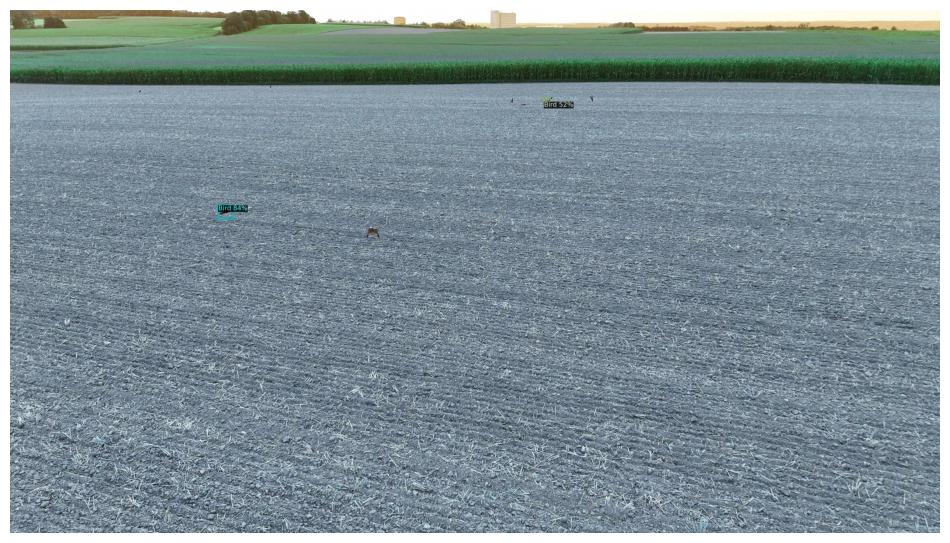

In [ ]:
# Load configuration
cfg = get_cfg()
cfg.merge_from_file("detectron2/configs/COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.WEIGHTS = "output/model_final.pth"  
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Confidence threshold for inference
cfg.DATASETS.TEST = ("scarecrow_val",)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # Set the number of classes in your dataset
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.1 #fixes overlapping boxes, this is a problem

# Initialize the predictor
predictor = DefaultPredictor(cfg)

image_path = "scarecrow_coco_dataset/test/test_original_13.png"  
im = cv2.imread(image_path)
outputs = predictor(im)

# Visualize the predictions
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TEST[0]), scale=1.0)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

# Display the image inline in Jupyter Notebook using Matplotlib
plt.figure(figsize=(12, 8))
plt.imshow(out.get_image()[:, :, ::-1])  # Convert from BGR to RGB
plt.axis("off")  # Turn off the axis
plt.show()
